###Updated code for StyleGAN2-ADA

In [ ]:
# check Python version
!python --version

Python 3.10.12


In [ ]:
# install required packages
!pip install torch torchvision librosa matplotlib tensorflow numpy scipy pillow requests tqdm

In [ ]:
# Clone the StyleGAN2-ADA repository
!git clone https://github.com/NVlabs/stylegan2-ada.git
%cd stylegan2-ada

fatal: destination path 'stylegan2' already exists and is not an empty directory.
/content/stylegan2
ERROR: Could not find a version that satisfies the requirement tensorflow==1.15 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0)
ERROR: No matching distribution found for tensorflow==1.15


In [ ]:
# install dependencies
!pip install -r requirements.txt

In [ ]:
# Download pre-trained StyleGAN2-ADA weights (FFHQ model)
!wget https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/ffhq.pkl

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github.com/wkentaro/gdown?tab=readme-ov-file#faq.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1tT21CET4RtpuoK98aBxF5muqRxk9z0B_

but Gdown can't. Please check connections and permissions.


###Audio processing

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


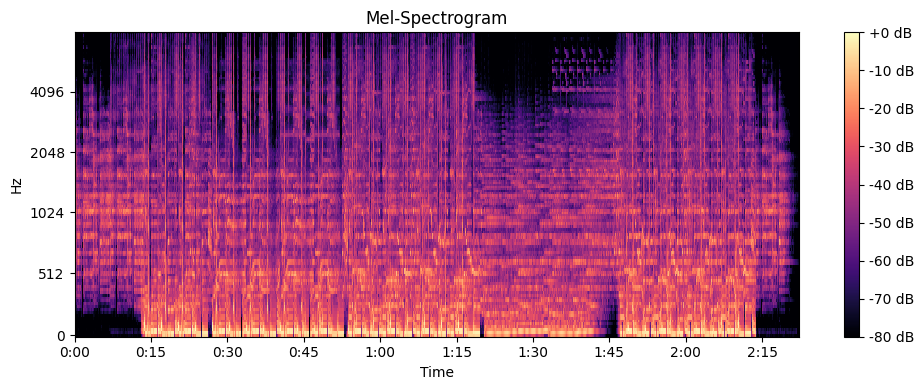

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# mount google drive
from google.colab import drive
drive.mount('/content/drive')

# access file in Google Drive:
from google.colab import files
file_path = '/content/drive/My Drive/sumu - apart [NCS Release].wav'
y, sr = librosa.load(file_path, sr=22050)

# Extract Mel-Spectrogram
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

# Visualize Spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram')
plt.tight_layout()
plt.show()

###VAE for Latent Space Encoding

In [ ]:
import torch
from torch import nn

# Define VAE
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        return z  # Only returning latent vector

# Instantiate VAE
latent_dim = 512  # StyleGAN2-ADA latent dimension
hidden_dim = 1024
input_dim = mel_spec_db.shape[0] * mel_spec_db.shape[1]  # Flattened spectrogram
vae = VAE(input_dim, hidden_dim, latent_dim)

# Generate Latent Vector
mel_spec_flat = mel_spec_db.flatten().astype(np.float32)
mel_spec_tensor = torch.tensor(mel_spec_flat).unsqueeze(0)  # Add batch dimension
latent = vae(mel_spec_tensor)
latent_vector = latent.detach().numpy()
print("Latent Vector Shape:", latent_vector.shape)


Latent Vector Shape: (1, 512)


###StyleGAN2 Integration


In [ ]:
import dnnlib
import legacy
import numpy as np
import PIL.Image

# Load Pre-Trained StyleGAN2 Model
model_path = '/content/drive/My Drive/ffhq.pkl' # file path to ffhq.pkl direct from drive
with dnnlib.util.open_url(model_path) as f:
    G = legacy.load_network_pkl(f)['G_ema']  # Load the generator

# Generate visuals using the latent vector
latent_vector = np.random.randn(1, G.z_dim)  # Random latent vector
img = G.synthesis(torch.from_numpy(latent_vector).to(torch.float32).cuda(), noise_mode='const')
img = (img + 1) * (255 / 2)  # Normalize to [0, 255]
img = np.clip(img.cpu().numpy().transpose(0, 2, 3, 1)[0], 0, 255).astype(np.uint8)

# Visualize the generated image
PIL.Image.fromarray(img).show()

ModuleNotFoundError: No module named 'tensorflow.contrib'

###Video Generation

In [ ]:
import cv2

# Initialize video writer
frame_size = (1024, 1024)  # StyleGAN2-ADA output resolution
out = cv2.VideoWriter('stylegan_video.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 10, frame_size)

# Generate and save frames
for i in range(100):  # Generate 100 frames
    latent_vector = np.random.randn(1, G.z_dim)  # Random latent vector
    img = G.synthesis(torch.from_numpy(latent_vector).to(torch.float32).cuda(), noise_mode='const')
    img = (img + 1) * (255 / 2)  # Normalize to [0, 255]
    img = np.clip(img.cpu().numpy().transpose(0, 2, 3, 1)[0], 0, 255).astype(np.uint8)

    # Write to video file
    out.write(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

out.release()
print("Video saved as 'stylegan_video.mp4'")
